In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [156]:
def quantile_error(y_pred, y_test, y_test_keys):
    """
    Calculate the average Quantile Loss at the 0.2 level for all materials.

    Args:
        y_pred: Predicted values (1D array, shape [N,]).
        y_test: Actual values (1D array, shape [N,]).
        y_test_keys: DataFrame with columns: rm_id, date (shape [N,]).

    Returns:
        QuantileError_02: Average quantile loss across all materials.
    """
    # Concatenate rm_id, y_test, and y_pred into a single DataFrame
    df = y_test_keys.copy()
    df["y_test"] = y_test
    df["y_pred"] = y_pred

    # Calculate the sum of actual and predicted values for each rm_id
    Ai = df.groupby("rm_id")["y_test"].cumsum()
    Fi = df.groupby("rm_id")["y_pred"].cumsum()

    q=0.2
    # Calculate Quantile Loss at 0.2 level for each rm_id
    quantile_loss = np.maximum(q * (Ai - Fi), (1-q) * (Fi - Ai))

    # Average quantile loss across all materials
    QuantileError_02 = np.mean(quantile_loss)

    return QuantileError_02

def flag_any(x, patterns):
    if not isinstance(x, str):
        return 0
    x = x.lower()
    return int(any(p in x for p in patterns))

def quantile_error_df(df):
    """
    Calculate the average Quantile Loss at the 0.2 level for all materials.

    Args:
        y_pred: Predicted values (1D array, shape [N,]).
        y_test: Actual values (1D array, shape [N,]).
        y_test_keys: DataFrame with columns: rm_id, date (shape [N,]).

        df already contain all these informations
    Returns:
        QuantileError_02: Average quantile loss across all materials.
    """

    # Calculate the sum of actual and predicted values for each rm_id
    Ai = df.groupby("rm_id", observed=False)["y_test"].cumsum()
    Fi = df.groupby("rm_id", observed=False)["y_pred"].cumsum()

    q=0.2
    # Calculate Quantile Loss at 0.2 level for each rm_id
    quantile_loss = np.maximum(q * (Ai - Fi), (1-q) * (Fi - Ai))

    # Average quantile loss across all materials
    QuantileError_02 = np.mean(quantile_loss)

    return QuantileError_02

def plot_history_vs_forecast(df_all, df_pred_2025, rm_id,start_date="2023-01-01"):
    # ensure types
    hist = df_all.loc[(df_all["rm_id"] == rm_id) & (df_all["date"] >= pd.Timestamp(start_date)), ["date", "net_weight"]].copy()
    pred = df_pred_2025.loc[df_pred_2025["rm_id"] == rm_id, ["date", "net_weight"]].copy()

    # plot
    plt.figure(figsize=(10, 5)) 
    plt.plot(hist["date"], hist["net_weight"], label="History")
    plt.plot(pred["date"], pred["net_weight"], label="Forecast")

    # reference line for forecast start (optional)
    fs = pd.Timestamp("2025-01-01")
    plt.axvline(fs, linestyle="--")

    plt.title(f"rm_id {rm_id} — net_weight: history vs forecast")
    plt.xlabel("Date")
    plt.ylabel("net_weight")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [157]:
#Fichier des predictions


# input dataframe : contains all rm_id, net_weight_sum and date (at least these three columns)
# name of the parameter : df_final



def print_submission(df_final, filename="submission.csv"):

    df_final["rm_id"] = pd.to_numeric(df_final["rm_id"], errors="coerce").astype("Int64")

    # 3) Load the ID mapping
    ids = pd.read_csv("./data/prediction_mapping.csv")  # or your actual path
    ids["forecast_start_date"] = pd.to_datetime(ids["forecast_start_date"])
    ids["forecast_end_date"]   = pd.to_datetime(ids["forecast_end_date"])
    ids["rm_id"]    = pd.to_numeric(ids["rm_id"], errors="coerce").astype("Int64")
    ids = ids.rename(columns={
        "forecast_end_date": "date"
    })

    # 4) For each ID, get cum at end_date (<= end_date)

    out = (
        ids.merge(df_final, on=["rm_id", "date"], how="left")
        .assign(cum=lambda d: d["cum"].fillna(0))   # cum=0 quand absent
        .sort_values(["rm_id", "date"])
        .reset_index(drop=True)
    )


    # 5) Cum at day before start_date
    submission = (
        out[["ID", "cum"]]
        .rename(columns={"cum": "predicted_weight"})   # if your file needs "predicted_weight"
        .fillna({"predicted_weight": 0})
        .sort_values("ID")
    )

    submission.to_csv("./submissions/" + filename, index=False)
    print(submission.head())


def RemoveOutliers(df,column):
        # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)

    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
        # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

        # Filter the DataFrame to exclude outliers
    df = df[
        (df[column] >= lower_bound) &
        (df[column] <= upper_bound)
    ]
    return df



In [158]:
purchase_orders = pd.read_csv('../data/kernel/purchase_orders.csv')
receivals = pd.read_csv('../data/kernel/receivals.csv')
transportation = pd.read_csv('../data/extended/transportation.csv')
materials = pd.read_csv('../data/extended/materials.csv')

purchase_orders["quantity"] = np.where(
    purchase_orders["unit"].str.lower().eq("pund"),
    purchase_orders["quantity"] * 0.453592,
    purchase_orders["quantity"]
)

purchase_orders['delivery_date'] = (
    pd.to_datetime(purchase_orders['delivery_date'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)
purchase_orders = purchase_orders.dropna(subset=['delivery_date'])
purchase_orders = purchase_orders[~purchase_orders["status"].isin(["Deleted"])]

receivals['date_arrival'] = (
    pd.to_datetime(receivals['date_arrival'], utc=True)
      .dt.tz_localize(None)
      .dt.normalize()
)
receivals = receivals.dropna(subset=['date_arrival'])

receivals_aggregated = (
    receivals
    .groupby(['purchase_order_id', 'purchase_order_item_no'])
    .agg({
        'date_arrival': 'mean',  # Average arrival date
        'net_weight': 'sum',      # Sum of net weight
        'rm_id': 'first'
    })
    .reset_index()
)
purchase_orders_subset = purchase_orders[
    ['purchase_order_id', 'purchase_order_item_no','product_id', 'quantity', 'delivery_date']
].copy()
# I don't manage the deleted localisation -> next feature ?
materials = materials.dropna(subset=["rm_id"])

materials["fam_6xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["6060","6063","6082","6005","6016"]))
materials["fam_5xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["5000","5754"]))
materials["fam_1xxx"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["1050","1100"]))
materials["fam_pure"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["99.5","99,5","99.7","99,7","cspa","pm al","granalla","coil"]))
materials["fam_scrap_shred"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["shredd","tritura","scrap"]))
materials["fam_briquetas"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["briquet","compact"]))
materials["fam_mele"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["melé","cacharro"]))
materials["fam_master"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, [" si "," mg "," mn "," cu "," cr "," fe ","ti-bors","wire","cable"]))
materials["treat_lacado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["lac","paint"]))
materials["treat_anodizado"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["anod"]))
materials["treat_thermal_break"] = materials["raw_material_alloy"].map(lambda x: flag_any(x, ["thermal break","puente t"]))

materials["loc_SB"] = materials["stock_location"].map(lambda x: flag_any(x, ["sb"]))
materials["loc_SA"] = materials["stock_location"].map(lambda x: flag_any(x, ["sa"]))
materials["loc_SC"] = materials["stock_location"].map(lambda x: flag_any(x, ["sc"]))
materials["loc_AA"] = materials["stock_location"].map(lambda x: flag_any(x, ["aa"]))
materials["loc_PM"] = materials["stock_location"].map(lambda x: flag_any(x, ["pm "]))

materials["loc_ThermalBreak"] = materials["stock_location"].map(lambda x: flag_any(x, ["thermal break","puente t"," pt"]))
materials["loc_Lavadero"] = materials["stock_location"].map(lambda x: flag_any(x, ["lavadero"]))
materials["loc_Granalla"] = materials["stock_location"].map(lambda x: flag_any(x, ["granalla"]))
materials["loc_Briquetas"] = materials["stock_location"].map(lambda x: flag_any(x, ["briquet"]))


# your flag columns already created above (fam_*, treat_*, loc_*)
flag_cols = [c for c in materials.columns if c.startswith(("fam_", "treat_", "loc_"))]

# Group and aggregate:
# - flags: max (so any 1 across the rm_id becomes 1)
# - format type: mean
# - keep a representative text for context (first)

materials_by_rm = (
    materials
    .groupby("rm_id", as_index=False)
    .agg({**{c: "mean" for c in flag_cols},
            "raw_material_format_type": "mean"})
)

# (optional) if you prefer ints for flags (0/1), cast them:
for c in flag_cols:
    materials_by_rm[c] = materials_by_rm[c].astype(int)


transportation = transportation.dropna(subset=["purchase_order_id","net_weight","rm_id"])

#df_nan = transportation[transportation["purchase_order_id"].isna()] # no more nan values
#print(df_nan) #now empty
weight_cols = ["vehicle_start_weight","vehicle_end_weight",
               "gross_weight","tare_weight","net_weight"]
for c in weight_cols:
    transportation[c] = pd.to_numeric(transportation[c], errors="coerce")

# --- One-hot encode transporter_name -> 0/1 columns
transp_dum = pd.get_dummies(
    transportation["transporter_name"],
    prefix="_",
    dummy_na=False  # set True if you want a "transp_nan" column for missing
)

# attach dummies
transportation = pd.concat([transportation, transp_dum], axis=1)

# --- Build aggregation dict:
#     - transporter dummies: mean (→ proportion of trips with that transporter per rm_id)
#     - weights: mean
agg_dict = {**{c: "max" for c in transp_dum.columns},
            **{c: "mean" for c in weight_cols}}

transportation_by_rm = (
    transportation
    .groupby("rm_id", as_index=False)
    .agg(agg_dict)
)

# pretty rounding for proportions/means
transportation_by_rm[transp_dum.columns] = transportation_by_rm[transp_dum.columns].round(3)
transportation_by_rm[weight_cols] = transportation_by_rm[weight_cols].round(3)
transportation_by_rm=transportation_by_rm.rename(columns={'net_weight': 'transp_mean_weight'})

merged_data = pd.merge(
    purchase_orders_subset,
    receivals_aggregated,
    on=['purchase_order_id', 'purchase_order_item_no'],
    how='left'  # Keep all purchase orders, even if no receivals exist
)
merged_data = merged_data.dropna(subset=['date_arrival', 'net_weight'])
merged_data['date_arrival'] = pd.to_datetime(merged_data['date_arrival']).dt.normalize()

#product_to_rm_id = dict(zip(materials['product_id'], materials['rm_id']))
#merged_data['rm_id'] = merged_data['product_id'].map(product_to_rm_id)

merged_data['order_year'] = merged_data['delivery_date'].dt.year
merged_data['order_month'] = merged_data['delivery_date'].dt.month
merged_data['order_dayofmonth'] = merged_data['delivery_date'].dt.day
merged_data['order_dayofweek'] = merged_data['delivery_date'].dt.dayofweek
merged_data['order_dayofyear'] = merged_data['delivery_date'].dt.dayofyear
merged_data['order_week'] = merged_data['delivery_date'].dt.isocalendar().week

merged_data['delay'] = (merged_data['date_arrival'] - merged_data['delivery_date']).dt.days
historical_delays = merged_data.groupby('rm_id')['delay'].mean().to_dict()
merged_data['historical_avg_delay'] = merged_data['rm_id'].map(historical_delays)
merged_data["rm_id"] = merged_data["rm_id"].astype("category")
#merged_data = pd.get_dummies(merged_data, columns=['rm_id'], prefix='prod')

merged_data=merged_data.drop(columns={"purchase_order_id", "purchase_order_item_no"})

merged_data = (
    merged_data
    .merge(materials_by_rm, on="rm_id", how="left")
    .merge(transportation_by_rm, on="rm_id", how="left")
)

merged_data=RemoveOutliers(merged_data,column="delay")
merged_data=RemoveOutliers(merged_data,column="quantity")
print(f"len : {len(merged_data)}")
print(merged_data.columns)

len : 18145
Index(['product_id', 'quantity', 'delivery_date', 'date_arrival', 'net_weight',
       'rm_id', 'order_year', 'order_month', 'order_dayofmonth',
       'order_dayofweek', 'order_dayofyear', 'order_week', 'delay',
       'historical_avg_delay', 'fam_6xxx', 'fam_5xxx', 'fam_1xxx', 'fam_pure',
       'fam_scrap_shred', 'fam_briquetas', 'fam_mele', 'fam_master',
       'treat_lacado', 'treat_anodizado', 'treat_thermal_break', 'loc_SB',
       'loc_SA', 'loc_SC', 'loc_AA', 'loc_PM', 'loc_ThermalBreak',
       'loc_Lavadero', 'loc_Granalla', 'loc_Briquetas',
       'raw_material_format_type', '__Transporter0', '__Transporter1',
       '__Transporter10', '__Transporter11', '__Transporter12',
       '__Transporter13', '__Transporter14', '__Transporter15',
       '__Transporter16', '__Transporter17', '__Transporter18',
       '__Transporter19', '__Transporter2', '__Transporter20',
       '__Transporter21', '__Transporter22', '__Transporter23',
       '__Transporter24', '__Transporte

The dataFrame is ready, now let's train the model (and create the training data)

In [159]:
columns_keys=["rm_id","product_id","delivery_date","date_arrival"]
columns_output = ['delay','net_weight']
columns_input = [c for c in merged_data.columns if ( (c not in columns_keys) and (c not in columns_output))]

def split_set_Train_Test(df_all, test_size=0.05):
    if test_size == 2024:
        train = df_all[df_all["date_arrival"] < pd.Timestamp("2024-01-01")]
        test = df_all[df_all["date_arrival"] >= pd.Timestamp("2024-01-01")]
    elif test_size == 0.:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date_arrival').iloc[:-1])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date_arrival').iloc[-1:])

    else:
        train = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date_arrival').iloc[:int((1-test_size) * len(x))])
        test = df_all.groupby('rm_id').apply(
            lambda x: x.sort_values('date_arrival').iloc[int((1-test_size) * len(x)):])

    X_train_keys= train[columns_keys].reset_index(drop=True)
    X_train = train[columns_input].reset_index(drop=True)
    y_train = train[columns_output].reset_index(drop=True)

    X_test_keys= test[columns_keys].reset_index(drop=True)
    X_test = test[columns_input].reset_index(drop=True)
    y_test = test[columns_output].reset_index(drop=True)

    
    return X_train_keys, X_train, y_train, X_test_keys, X_test, y_test

In [160]:
X_train_keys,X_train, y_train, X_test_keys, X_test, y_test = split_set_Train_Test(merged_data, test_size=2024)
print(X_train_keys.head())
print(X_train.head())
print(y_train.head())
print(X_test_keys.head())
print(X_test.head())
print(y_test.head())

    rm_id  product_id delivery_date date_arrival
0  2159.0    91900296    2012-07-30   2012-07-10
1  2182.0    91901050    2012-07-30   2012-07-09
2  2182.0    91901050    2012-07-30   2012-07-12
3  2182.0    91901050    2012-07-30   2012-07-12
4   375.0    91900302    2004-12-30   2004-11-28
   quantity  order_year  order_month  order_dayofmonth  order_dayofweek  \
0  150000.0        2012            7                30                0   
1  150000.0        2012            7                30                0   
2  150000.0        2012            7                30                0   
3  150000.0        2012            7                30                0   
4  100000.0        2004           12                30                3   

   order_dayofyear  order_week  historical_avg_delay  fam_6xxx  fam_5xxx  ...  \
0              212          31             -7.452174         1         0  ...   
1              212          31            -21.460296         1         0  ...   
2           

In [161]:

# Initialize the model
model = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=1000, random_state=42)
)
# Train the model
model.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(n_estimators=1000,
                                                     random_state=42))

In [162]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred= pd.DataFrame(y_pred)
y_pred.columns=["pred_delay","pred_net_weight"]

output= pd.concat([X_test_keys , y_pred, y_test], axis=1)
output["pred_date_arrival"]= output["delivery_date"] + pd.to_timedelta(output["pred_delay"], unit="D")
output["pred_date_arrival"] = pd.to_datetime(output["pred_date_arrival"])
output["date_arrival"] = pd.to_datetime(output["date_arrival"])
#output["predicted_arrival"]
# 1️⃣ Create full daily date range for 2024
dates_2024 = pd.date_range("2024-01-01", "2024-12-31", freq="D")

# 2️⃣ Get all unique rm_id
rm_ids = output["rm_id"].unique()

# 3️⃣ Cartesian product of rm_id × all 2024 dates
full_grid = pd.MultiIndex.from_product(
    [rm_ids, dates_2024], names=["rm_id", "date"]
).to_frame(index=False)

# 4️⃣ Merge predicted and real deliveries
merged = (
    full_grid
    .merge(output[["rm_id", "pred_date_arrival", "pred_net_weight"]],
           left_on=["rm_id", "date"],
           right_on=["rm_id", "pred_date_arrival"],
           how="left")
    .merge(output[["rm_id", "date_arrival", "net_weight"]],
           left_on=["rm_id", "date"],
           right_on=["rm_id", "date_arrival"],
           how="left")
)

# 5️⃣ Fill missing values with 0
merged = merged.fillna({
    "pred_net_weight": 0,
    "net_weight": 0
})

# optional: tidy up columns
merged = merged.drop(columns=["pred_date_arrival", "date_arrival"])
merged = merged.rename(columns={
    "pred_net_weight": "y_pred",
    "net_weight": "y_test"
})
quantile_error_net_weight = quantile_error_df(merged)
print(quantile_error_net_weight)

61140.06007556675


argmin is -0.15000000000014424
min is 61140.06007556675


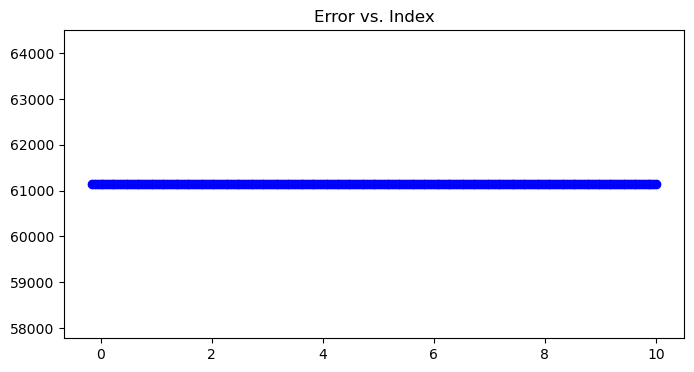

In [163]:
df=merged.copy()
err_min=np.inf
alpha_min=1
errs=[]
for alpha in np.arange(10, -0.2, -0.05):
    df["y_pred"] = alpha*merged["y_pred"]
    err = quantile_error_df(df)
    errs.append(err)
    if err <= err_min:
        alpha_min = alpha
        err_min=err
print(f"argmin is {alpha_min}")
print(f"min is {err_min}") # before = 57288 / 59718 / 58290
plt.figure(figsize=(8, 4))  # Optional: Set figure size
plt.plot(np.arange(10, -0.2, -0.05), errs, marker='o', linestyle='-', color='b')  # Plot with markers and line
plt.title('Error vs. Index')  # Title
plt.show()  # Display the plot



C:\Users\julie\AppData\Local\Temp\ipykernel_4796\2138849730.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_delay, palette='viridis')


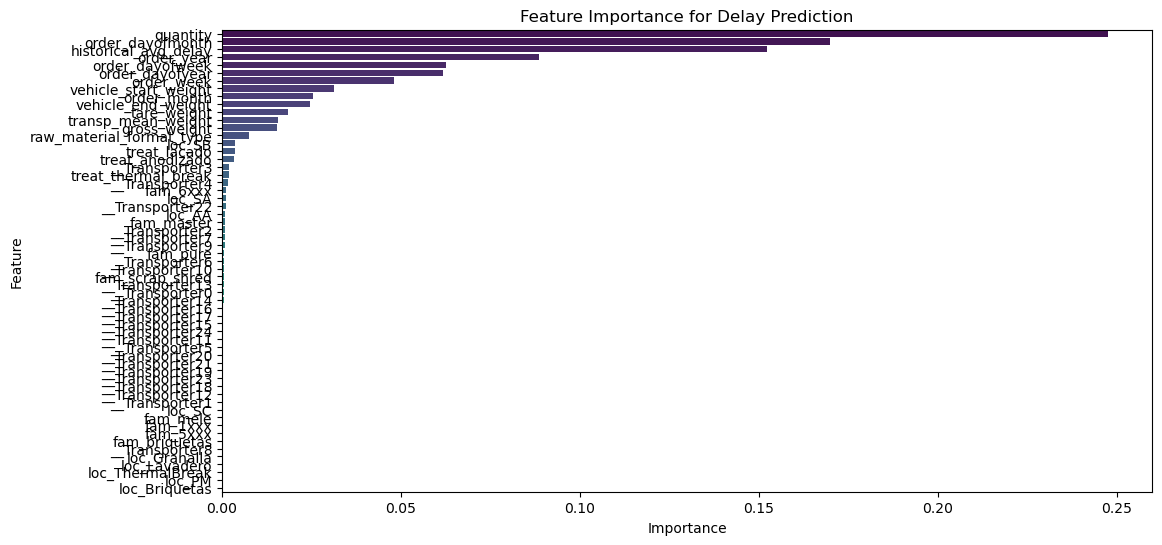

C:\Users\julie\AppData\Local\Temp\ipykernel_4796\2138849730.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_net_weight, palette='viridis')


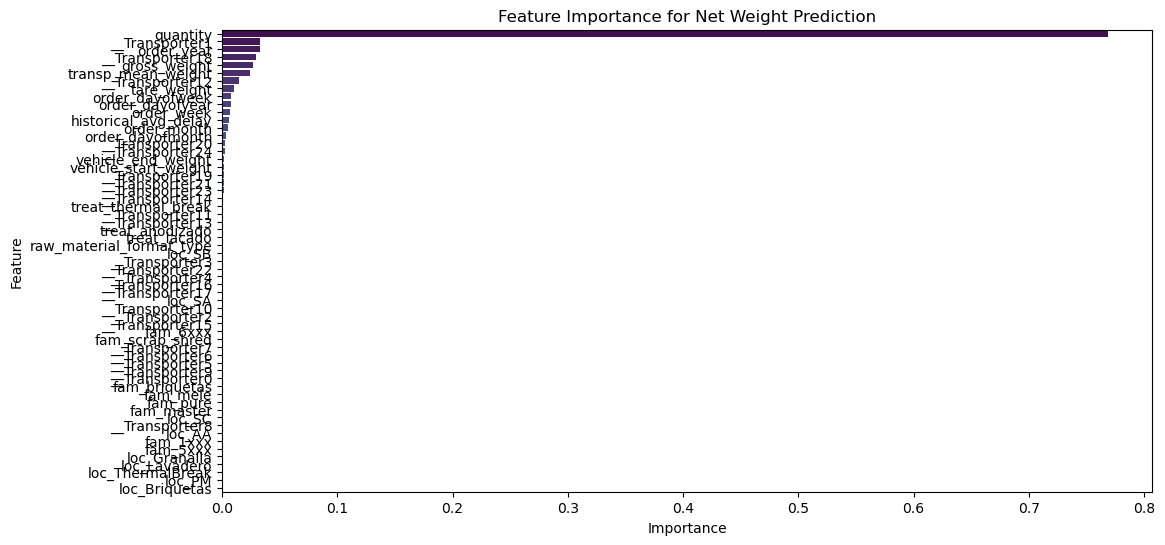

In [164]:
# Feature Importance
rf_delay = model.estimators_[0]
rf_net_weight = model.estimators_[1]

importances_delay = rf_delay.feature_importances_
importances_net_weight = rf_net_weight.feature_importances_


# Create a DataFrame for feature importances for delay
feature_importance_delay = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_delay
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for delay
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_delay, palette='viridis')
plt.title('Feature Importance for Delay Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Create a DataFrame for feature importances for net weight
feature_importance_net_weight = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_net_weight
}).sort_values(by='Importance', ascending=False)

# Plot feature importance for net weight
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_net_weight, palette='viridis')
plt.title('Feature Importance for Net Weight Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Forcasting :

In [165]:
data_2025 = purchase_orders[purchase_orders["delivery_date"] >= pd.Timestamp("2025-01-01")].copy()
data_2025 = data_2025[ ['product_id', 'quantity', 'delivery_date']]

data_2025['order_year'] = data_2025['delivery_date'].dt.year
data_2025['order_month'] = data_2025['delivery_date'].dt.month
data_2025['order_dayofmonth'] = data_2025['delivery_date'].dt.day
data_2025['order_dayofweek'] = data_2025['delivery_date'].dt.dayofweek
data_2025['order_dayofyear'] = data_2025['delivery_date'].dt.dayofyear
data_2025['order_week'] = data_2025['delivery_date'].dt.isocalendar().week

product_to_rm_id = dict(zip(merged_data['product_id'], merged_data['rm_id']))
data_2025['rm_id'] = data_2025['product_id'].map(product_to_rm_id)
data_2025['historical_avg_delay'] = data_2025['rm_id'].map(historical_delays)
data_2025["rm_id"] = data_2025["rm_id"].astype("category")

X_for = data_2025[columns_input]
y_for = model.predict(X_for)

predictions_df = pd.DataFrame(y_for, columns=['predicted_delay', 'predicted_net_weight'])
data_2025 = data_2025.reset_index(drop=True)
predictions_df = predictions_df.reset_index(drop=True)
data_2025 = pd.concat([data_2025, predictions_df], axis=1)
data_2025['predicted_date_arrival'] = data_2025['delivery_date'] + pd.to_timedelta(data_2025['predicted_delay'], unit='D')
data_2025['predicted_date_arrival'] = pd.to_datetime(data_2025['predicted_date_arrival'], utc=True).dt.tz_localize(None).dt.normalize()

final_pred=(  
    data_2025[['rm_id','predicted_date_arrival','predicted_net_weight']  ]
    .groupby(['rm_id', 'predicted_date_arrival'], as_index=False, observed=True)
    .agg({'predicted_net_weight': 'sum'})
)



unique_rm_ids = final_pred['rm_id'].unique()
all_dates = pd.date_range(start='2025-01-01', end='2025-05-31', freq='D')
multi_index = pd.MultiIndex.from_product(
    [unique_rm_ids, all_dates],
    names=['rm_id', 'predicted_date_arrival']
)
# Set the index of final_pred to rm_id and predicted_date_arrival
final_pred = final_pred.set_index(['rm_id', 'predicted_date_arrival'])

# Reindex to the MultiIndex and fill missing values with 0
final_pred = final_pred.reindex(multi_index, fill_value=0).reset_index()

final_pred = final_pred.sort_values(["rm_id", "predicted_date_arrival"])
final_pred["cum"] = (
    final_pred.groupby("rm_id", observed=True)["predicted_net_weight"]
              .cumsum()
              
)
final_pred=final_pred.rename(columns={"predicted_date_arrival": "date"})


KeyError: "['fam_6xxx', 'fam_5xxx', 'fam_1xxx', 'fam_pure', 'fam_scrap_shred', 'fam_briquetas', 'fam_mele', 'fam_master', 'treat_lacado', 'treat_anodizado', 'treat_thermal_break', 'loc_SB', 'loc_SA', 'loc_SC', 'loc_AA', 'loc_PM', 'loc_ThermalBreak', 'loc_Lavadero', 'loc_Granalla', 'loc_Briquetas', 'raw_material_format_type', '__Transporter0', '__Transporter1', '__Transporter10', '__Transporter11', '__Transporter12', '__Transporter13', '__Transporter14', '__Transporter15', '__Transporter16', '__Transporter17', '__Transporter18', '__Transporter19', '__Transporter2', '__Transporter20', '__Transporter21', '__Transporter22', '__Transporter23', '__Transporter24', '__Transporter3', '__Transporter4', '__Transporter5', '__Transporter6', '__Transporter7', '__Transporter8', '__Transporter9', 'vehicle_start_weight', 'vehicle_end_weight', 'gross_weight', 'tare_weight', 'transp_mean_weight'] not in index"

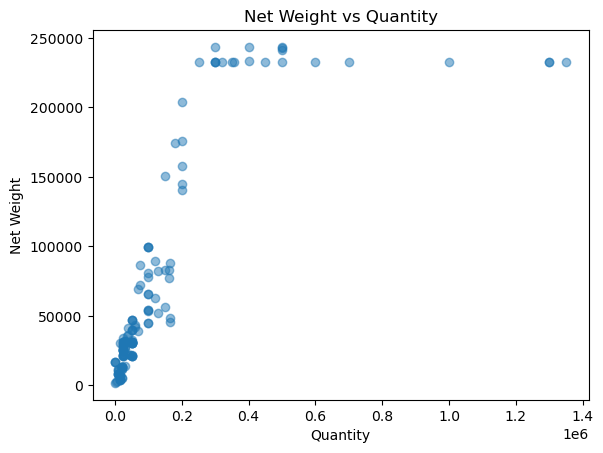

count    2.567000e+03
mean     3.893834e+03
std      8.168663e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.813253e+06
Name: predicted_net_weight, dtype: float64
count    2.567000e+03
mean     3.770885e+05
std      8.783372e+05
min      0.000000e+00
25%      2.162830e+03
50%      4.994875e+04
75%      3.673997e+05
max      4.572386e+06
Name: cum, dtype: float64


In [ ]:
plt.scatter(data_2025['quantity'], data_2025['predicted_net_weight'], alpha=0.5)
plt.xlabel('Quantity')
plt.ylabel('Net Weight')
plt.title('Net Weight vs Quantity')
plt.show()

print(final_pred['predicted_net_weight'].describe())

print(final_pred['cum'].describe())

In [ ]:
print_submission(final_pred[["rm_id", "date","cum"]],filename="orders_to_receival_AI.csv")

C:\Users\julie\AppData\Local\Temp\ipykernel_4796\4199745209.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["rm_id"] = pd.to_numeric(df_final["rm_id"], errors="coerce").astype("Int64")


FileNotFoundError: [Errno 2] No such file or directory: './data/prediction_mapping.csv'